# Generative Adversarial Networks

Como vimos em autocodificadores variacionais, há possivelmente muitos códigos latentes que representam uma certa imagem. Também sabemos que há muito ruído no espaço de entrada, o que nos permite representar uma entrada por um código latente muito menor. 

Logo, talvez seja possível introduzir ruído em uma entrada, cuidadosamente, sem modificá-la de forma perceptível aos olhos humanos, mas modificando-a significativamente em sua representação latente (ou seja, o "ruído" introduzido não é de fato ruído, mas valores escolhidos cuidadosamente para não mudarem significativamente a relação entre os atributos, mas levando-os para fora das suas faixas de valores esperados). Abaixo, temos uma ilustração desta ideia, onde à imagem de um panda é adicionado ruído $\epsilon$, de forma que a imagem resultante é vista como um gibão pela rede neural, embora pareça ainda um panda para um ser humano.

<img src="images/adversarial_img_1.png" alt="GAN" style="width: 500px;"/>

Este é naturalmente um problema, uma vez que é possível fazer redes neurais cometerem erros modificando cuidadosamente os exemplos dados. Vários estudos têm sido realizados para tornar estes modelos mais robustos a este tipo de erro. Uma estratégia, por exemplo, é treinar a rede neural com exemplos destes casos (chamados adversariais), o que nos leva à seguinte questão:

Seria possível criar um modelo discriminador $D$ capaz de aprender o que faz uma imagem real ser real ao olho humando e, assim, discriminá-la de imagens falsas? 

Se sim, então é viável imaginar também que seria possível criar _modelos geradores de imagens falsas que, em competição com $D$, fossem capazes de criar imagens tão convincentes a ponto de $D$ não ser mais capaz de diferenciá-las de imagens verdadeiras!_ 

O _insight_ acima nos leva à proposição das Redes Geradoras Adversariais (GANs -- _Generated Adversarial Networks_, Goodfellow _et al_, 2014 -- https://arxiv.org/abs/1406.2661). GANs são combinações de redes neurais que treinam de forma competitiva. Mais especificamente, GANs são formadas por duas redes, uma discriminadora (_D_) e uma geradora (_G_). Sem perda de generalidade, suponha que temos uma GAN projetada para gerar imagens. A rede discriminadora _D_ desta GAN é treinada em imagens reais e imagens da rede geradora _G_ e tem por objetivo determinar _que imagens são as de G_. O objetivo de _G_, por sua vez, é gerar imagens que _D_ não consiga discernir das imagens reais. Logo, se _G_ for bem sucedida, ela gera imagens mais realistas.  

Esta ideia tem sido aplicada com grande sucesso na resolução de muitas tarefas (geração de faces, ambientes, fotos; geração de imagens apartir e fotos; geração de texto apartir de exemplos de texto; geração de imagens apartir de exemplos de imagens; criação e analogias; criação de imagens/textos apartir de exemplos; obtenção de imagens de alta resolução de imagens de baixa resolução, etc), de forma a tornar modelos geradores especialmente úteis atualmente. 

## Como funcionam GANs?

Para entendermos melhor, a figura abaixo ilustra uma GAN. Nesta figura, $p_{data}(x)$ é a distribuição de probabilidade real dos dados; $x$ é uma amostra tirada de $p_{data}(x)$; $p(z)$ é a distribuição de probabilidade do gerador, onde $z$ é uma amostra de $p(z)$; G(x) é a rede geradora e D(x) a discriminadora.

<img src="images/gan1.jpg" alt="GAN" style="width: 500px;"/>

A rede geradora $G$ gera um novo dado apartir de uma amostra aleatória $z$ obtida da distribuição de probabilidade $p(z)$. O dado gerado é fornecido como entrada para o discriminador $D(x)$. A tarefa do discriminador é distinguir entradas reais das geradas. Para isso, ele obtem uma entrada $x$ da distribuição de dados reais $p_{data}(x)$. Assim, $D(x)$ apenas tem que classificar as entradas, forncecendo uma estimativa probabilística sobre se elas são geradas ou reais.

O treinamento da GAN pode ser expresso como uma disputa entre $G$ e $D$, ou seja, a meta é $G$ minimizar a capacidade de discriminação que $D$ está tentando maximizar. Isto pode ser expresso com ajuda da seguinte função:

$$V(G, D) = E_{x \sim p_{data}(x)}[\log D(x)] + E_{z \sim p(z)}[\log (1 - D(G(z)))]$$

Na função $V$, o primeiro termo designa a esperança de que os dados da distribuição real $p(x)$ sejam reconhecidos como reais por D. O segundo termo é esperança de que os dados gerados de $p(z)$ serão identificados como falsos por D. Logo, o objetivo de $D$ é maximizar $V$ enquanto $G$ quer minimizar $V$ (ou seja, temos uma corrida armamentista entre $D$ e $G$ -- cada um vai querer se especializar nos pontos fracos do outro):

$$
\DeclareMathOperator*{\min}{min}
\DeclareMathOperator*{\max}{max}
\max_{D} + \min_{G}{V(G, D) = E_{x \sim p_{data}(x)}[\log D(x)] + E_{z \sim p(z)}[\log (1 - D(G(z)))]}
$$

Do ponto de vista do Discriminador, o objetivo é:

$$
\DeclareMathOperator*{\min}{min}
\DeclareMathOperator*{\max}{max}
\max_{D} {E_{x \sim p_{data}(x)}[\log D(x)] + E_{z \sim p(z)}[\log (1 - D(G(z)))]}
$$

Do ponto de vista do Gerador, o objetivo se reduz a:

$$
\DeclareMathOperator*{\min}{min}
\min_{G}{E_{z \sim p(z)}[\log (1 - D(G(z)))]}
$$

Note que, na prática, especialmente no início do treino, o valor esperado para $D(G(z))$ é próximo de zero porque as imagens são muito ruins e o discriminador as reconhece como falsas sem muito esforço. Assim, um objetivo melhor para o gerador é:

$$
\DeclareMathOperator*{\min}{min}
\max_{G}{E_{z \sim p(z)}[\log (D(G(z)))]}
$$

porque esta segunda função produz gradientes melhores nas imediações de 0:

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

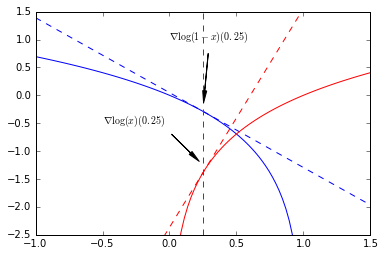

In [11]:
def tan(f, x, a = 0.25, h = 0.01):
    fprime = (f(a+h)-f(a))/h # derivative
    return f(a)+fprime*(x-a)  # tangent

f0 = lambda x: np.log(1-x)
f1 = lambda x: np.log(x)

# ignore divide-error and invalid number errors
with np.errstate(all='ignore'): 
    x = np.linspace(-1.0, 1.5, 100)
    plt.plot(x, f0(x), 'b')
    plt.plot(x, tan(f0, x), 'b--')
    plt.plot(x, f1(x), 'r')
    plt.plot(x, tan(f1, x), 'r--')
    plt.axvline(x = 0.25, color='g', linestyle='--')
    plt.annotate(r'$\nabla \log(1-x)(0.25)$', xy=(0.25, -0.25), xytext=(0, 1),
                arrowprops=dict(facecolor='black', shrink=0.1, 
                                width=0.1, headwidth=4))
    plt.annotate(r'$\nabla \log(x)(0.25)$', xy=(0.25, -1.25), xytext=(-0.5, -0.5),
                arrowprops=dict(facecolor='black', shrink=0.1, 
                                width=0.1, headwidth=4))
    plt.ylim(-2.5,1.5)

## Implementando uma GAN com Keras e Tensorflow

Nesta aula, vamos treinar uma GAN para gerar dígitos da MNIST. Para isso, vamos ler os dígitos da MNIST.

In [12]:
from __future__ import print_function

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import sys

Using TensorFlow backend.


In [13]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST_data")

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


Os dados da MNIST serão normalizados para ficarem entre -1 e 1.

In [14]:
# Load the dataset
X_train = mnist.train.images

# Rescale -1 to 1, 28x28
X_train = (X_train.astype(np.float32) - 0.5) / 0.5
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

As funções abaixo são apenas para visualizarmos melhor o andamento do treino. A função `smooth` suaviza um série de dados usando média móvel e a função `plot_images` exibe 8 imagens aleatórias dos dígitos sendo gerados pela GAN, para observamos se a rede esta evoluindo com o tempo.

In [15]:
# moving average smoothing
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [16]:
def plot_imgs(epoch, generator, cols = 8):
    noise = np.random.normal(0, 1, (cols, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    f, axes = plt.subplots(1, cols)
    for i, a in enumerate(axes):
        a.imshow(gen_imgs[i,:,:,0], cmap = 'gray', interpolation='nearest')
        a.axis('off')
    plt.show()

A arquitetura da rede que vamos implementar é ilustrada na figura a seguir. A rede é composta por dois componentes, o gerador e o discriminador. A entrada do gerador são 100-D vetores aleatórios enquanto a sua saída são imagens 28x28, como as da MNIST. O componente gerador é treinado para aprender se uma imagem é real. A figura também indica que no treinamento do discriminador, ele recebe tanto imagens reais quanto geradas pelo gerador. Por sua vez, no treino do gerador, imagens reais não são usadas.

<img src="images/ganmodel0.png" alt="GAN to implement" style="width: 600px;"/>

In [17]:
img_rows = 28 
img_cols = 28
channels = 1
noise_shape = (100,)
img_shape = (img_rows, img_cols, channels)

A seguir temos a implementação do gerador em Keras. O ruído de entrada é dado por um 100-D vetor aleatório. Usamos leakyRelu e BatchNormalization nas camadas ocultas. A camada final usa tangente hiperbólica para gerar imagens com pixels entre -1 a 1, como as imagens reais.

In [19]:
def build_generator(noise_shape = (100,), 
                    img_shape = (28, 28, 1)):
    gen = Sequential()
    gen.add(Dense(256, input_shape=noise_shape))
    gen.add(LeakyReLU(alpha=0.2))
    gen.add(BatchNormalization(momentum=0.8))
    gen.add(Dense(512))
    gen.add(LeakyReLU(alpha=0.2))
    gen.add(BatchNormalization(momentum=0.8))
    gen.add(Dense(1024))
    gen.add(LeakyReLU(alpha=0.2))
    gen.add(BatchNormalization(momentum=0.8))
    gen.add(Dense(np.prod(img_shape), activation='tanh'))
    gen.add(Reshape(img_shape))
    gen.summary()

    gen_input = Input(shape=noise_shape)
    gen_output = gen(gen_input)
    return Model(gen_input, gen_output)

In [20]:
optimizer = Adam(lr = 0.0002, beta_1 = 0.5)

# Build and compile the generator
generator = build_generator(noise_shape, img_shape)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
__________

A seguir temos a implementação do _discriminador_ em Keras. Esta é uma rede densa tradicional, sem BatchNormalization, e com LeakyRelu. A camada final usa sigmoid para gerar estimativas que funcionem como probabilidades (0 a 1).

In [21]:
def build_discriminator(img_shape = (28, 28, 1)):
    disc = Sequential()
    disc.add(Flatten(input_shape=img_shape))
    disc.add(Dense(512))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Dense(256))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Dense(1, activation='sigmoid'))
    disc.summary()

    disc_input = Input(shape=img_shape)
    disc_output = disc(disc_input)
    return Model(disc_input, disc_output)

In [22]:
# Build and compile the discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', 
    optimizer=optimizer,
    metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


A GAN, em si, é uma combinação do gerador com o discriminador. Assim, definimos nossa rede combinada como o gerador conectado ao discriminador. Note que na rede combinada, o discriminador não é treinável. Na prática, ele será treinado em separado.

In [23]:
# The generator takes noise as input and generated imgs
z = Input(noise_shape)
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The valid takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Finalmente, chegamos ao treino. A ideia geral do treino é dada abaixo (considere $b$ o tamanho do _batch_):

* Para cada época:
    * Treine o discriminador (ou seja, apenas a rede Discriminator)
        * Usando $b/2$ imagens do gerador rotuladas como falsas (0)
        * Usando $b/2$ imagens reais (do batch) rotuladas como reais (1)
    * Treine o gerador (ou seja, a rede inteira, combinada, com o Discriminator 'congelado')
        * Usando $b$ imagens do gerador rotuladas como reais (1), pois o gerador G quer _enganar_ o discriminador D. O resultado desta estratégia é que se D achar que uma imagem enviada por G é real, ele foi efetivamente enganado e nada precisa mudar em G. Se, por outro lado, D achar que é falsa, então G precisa mudar sua estratégia, uma vez que D não foi enganado.

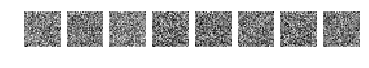

    0 [D loss: 0.871975, acc.: 15.62%] [G loss: 0.550555]
  400 [D loss: 0.693839, acc.: 43.75%] [G loss: 0.640828]
  800 [D loss: 0.703902, acc.: 53.12%] [G loss: 0.782860]
 1200 [D loss: 0.588616, acc.: 84.38%] [G loss: 0.826381]


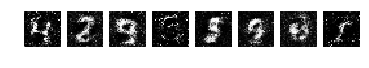

 1600 [D loss: 0.568031, acc.: 71.88%] [G loss: 0.900436]
 2000 [D loss: 0.602565, acc.: 56.25%] [G loss: 0.924755]
 2400 [D loss: 0.579926, acc.: 75.00%] [G loss: 0.913115]
 2800 [D loss: 0.682803, acc.: 56.25%] [G loss: 0.920057]


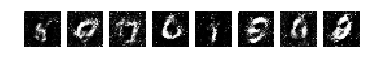

 3200 [D loss: 0.652733, acc.: 65.62%] [G loss: 0.845752]
 3600 [D loss: 0.598498, acc.: 68.75%] [G loss: 0.785482]
 4000 [D loss: 0.721382, acc.: 50.00%] [G loss: 0.945411]
 4400 [D loss: 0.688477, acc.: 56.25%] [G loss: 1.010409]


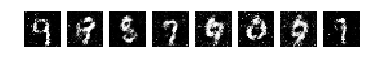

 4800 [D loss: 0.647010, acc.: 53.12%] [G loss: 0.906769]
 5200 [D loss: 0.640261, acc.: 62.50%] [G loss: 0.851825]
 5600 [D loss: 0.627422, acc.: 65.62%] [G loss: 0.790030]
 6000 [D loss: 0.671876, acc.: 59.38%] [G loss: 0.840024]


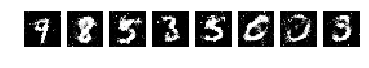

 6400 [D loss: 0.630522, acc.: 56.25%] [G loss: 0.842513]
 6800 [D loss: 0.562778, acc.: 75.00%] [G loss: 0.971390]
 7200 [D loss: 0.675960, acc.: 62.50%] [G loss: 0.832630]
 7600 [D loss: 0.686051, acc.: 53.12%] [G loss: 0.895766]


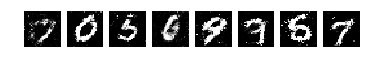

 8000 [D loss: 0.655308, acc.: 56.25%] [G loss: 0.827341]
 8400 [D loss: 0.641392, acc.: 56.25%] [G loss: 0.858386]
 8800 [D loss: 0.631602, acc.: 59.38%] [G loss: 0.836776]
 9200 [D loss: 0.688574, acc.: 50.00%] [G loss: 0.880122]


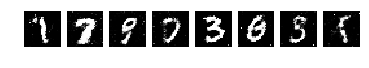

 9600 [D loss: 0.671482, acc.: 50.00%] [G loss: 0.903934]
10000 [D loss: 0.799505, acc.: 37.50%] [G loss: 0.841470]
10400 [D loss: 0.694805, acc.: 59.38%] [G loss: 0.910862]
10800 [D loss: 0.650087, acc.: 62.50%] [G loss: 0.875453]


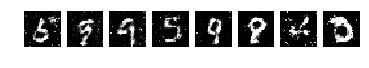

11200 [D loss: 0.700197, acc.: 62.50%] [G loss: 0.846751]
11600 [D loss: 0.586140, acc.: 71.88%] [G loss: 0.846924]
12000 [D loss: 0.676646, acc.: 56.25%] [G loss: 0.827142]
12400 [D loss: 0.748623, acc.: 50.00%] [G loss: 0.883766]


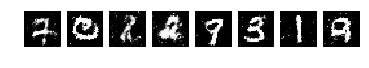

12800 [D loss: 0.668269, acc.: 65.62%] [G loss: 0.900597]
13200 [D loss: 0.691870, acc.: 59.38%] [G loss: 0.859584]
13600 [D loss: 0.712352, acc.: 56.25%] [G loss: 0.954213]
14000 [D loss: 0.683444, acc.: 59.38%] [G loss: 0.853527]


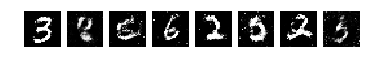

14400 [D loss: 0.663383, acc.: 62.50%] [G loss: 0.867816]
14800 [D loss: 0.698106, acc.: 50.00%] [G loss: 0.888435]
15200 [D loss: 0.668992, acc.: 59.38%] [G loss: 0.842315]
15600 [D loss: 0.550244, acc.: 87.50%] [G loss: 0.867539]


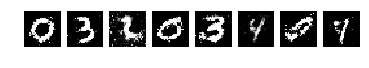

16000 [D loss: 0.722291, acc.: 46.88%] [G loss: 0.871633]
16400 [D loss: 0.587539, acc.: 75.00%] [G loss: 0.851341]
16800 [D loss: 0.618732, acc.: 65.62%] [G loss: 0.960884]
17200 [D loss: 0.699513, acc.: 50.00%] [G loss: 0.836080]


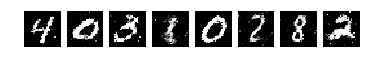

17600 [D loss: 0.777941, acc.: 43.75%] [G loss: 0.773568]
18000 [D loss: 0.693882, acc.: 56.25%] [G loss: 0.883326]
18400 [D loss: 0.737134, acc.: 40.62%] [G loss: 0.847567]
18800 [D loss: 0.725818, acc.: 46.88%] [G loss: 0.883950]


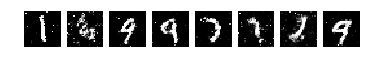

19200 [D loss: 0.672328, acc.: 62.50%] [G loss: 0.893328]
19600 [D loss: 0.714292, acc.: 53.12%] [G loss: 0.850872]
20000 [D loss: 0.711762, acc.: 50.00%] [G loss: 0.877712]
20400 [D loss: 0.743436, acc.: 50.00%] [G loss: 0.913499]


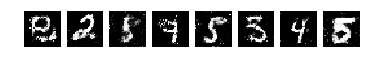

20800 [D loss: 0.682448, acc.: 53.12%] [G loss: 0.833266]
21200 [D loss: 0.701985, acc.: 50.00%] [G loss: 0.807831]
21600 [D loss: 0.596161, acc.: 65.62%] [G loss: 0.863805]
22000 [D loss: 0.639098, acc.: 65.62%] [G loss: 0.814666]


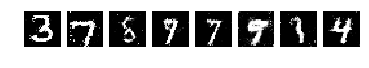

22400 [D loss: 0.617325, acc.: 62.50%] [G loss: 0.886247]
22800 [D loss: 0.676851, acc.: 46.88%] [G loss: 0.840127]
23200 [D loss: 0.584040, acc.: 71.88%] [G loss: 0.923553]
23600 [D loss: 0.754887, acc.: 40.62%] [G loss: 0.825891]


In [11]:
epochs = 24000 # 4800 # 30000 
batch_size = 32 
progress_interval = 400
save_interval = 1600

d_losses = []
d_accs = []
g_losses = []

half_batch = int(batch_size / 2)

for e in range(epochs):

    # If at save interval => save generated image samples
    if e % save_interval == 0:
        plot_imgs(e, generator)
        
    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (half_batch, 100)) # N(mu=0, sigma=1)

    # Generate a half batch of new images
    gen_imgs = generator.predict(noise)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    d_losses += [d_loss[0]]
    d_accs += [d_loss[1]]

    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, 100))

    # The generator wants the discriminator to label the generated samples
    # as valid (ones)
    valid_y = np.array([1] * batch_size)

    # Train the generator
    g_loss = combined.train_on_batch(noise, valid_y)
    g_losses += [g_loss]

    # Plot the progress
    if e % progress_interval == 0:
        print ("%5d [D loss: %.6f, acc.: %.2f%%] [G loss: %.6f]" % 
               (e, d_loss[0], 100*d_loss[1], g_loss))


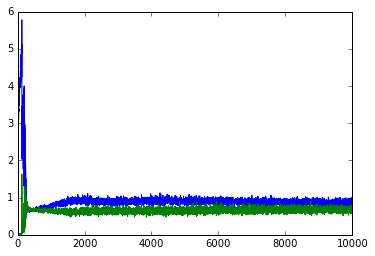

In [14]:
plt.plot(g_losses[:10000])
plt.plot(d_losses[:10000])

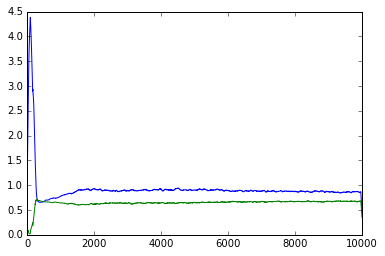

In [21]:
plt.plot(smooth(g_losses[:10000], 70))
plt.plot(smooth(d_losses[:10000], 70))

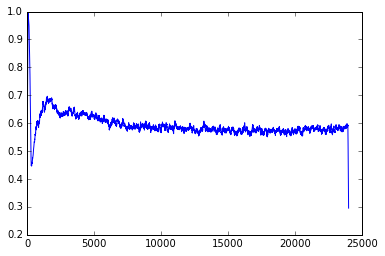

In [22]:
plt.plot(smooth(d_accs, 100))

Note que não há um critério muito claro de parada aqui. Você deve checar manualmente a qualidade dos dados gerados para ver se eles são apropriados e já é possível parar. Mas uma vez que você tem um gerador confiável e funcional, você pode replicar qualquer dígito. Em uma escala maior, você pode replicar coisas como textos de reviews, fotos, músicas... você tem uma máquina que parece efetivamente inteligente.

## Outras arquiteturas para GANs

Muitas novas arquiteturas de GANs têm surgido na literatura. O site https://deephunt.in/the-gan-zoo-79597dc8c347 dá uma boa ideia da imensa diversidade de ideias nessa área. Abaixo, citamos algumas com implementações disponíveis:

* __ACGAN__ -- Auxiliary Classifier Generative Adversarial Network. Paper: https://arxiv.org/abs/1610.09585. Implementação: https://github.com/eriklindernoren/Keras-GAN/blob/master/acgan/acgan.py. 
    ACGANs representam uma evolução na classe das GANs condicionais:
    * __CGAN__: Conditional GAN. Classe da entrada é fornecida junto com a entrada, de forma que o gerador pode amostrar casos da classe dada. Por exemplo, ao entrar com a classe 3 para um gerador treinado na MNIST, espera-se que ele gere um exemplo do dígito 3. Paper: https://arxiv.org/abs/1411.1784, Implementation (pytorch):  https://github.com/wiseodd/generative-models
    * __SGAN__ -- Semi-supervised Generative Adversarial Network. Na SGAN, a classe é codificada como parte do vetor de entrada e o discriminador prevê a classe na saída. Logo, ele força mais ainda o aprendizado do contexto de entrada. Paper: https://arxiv.org/abs/1606.01583. Implementação: https://github.com/eriklindernoren/Keras-GAN/blob/master/sgan/sgan.py.
    * __InfoGAN__ -- Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets. Como a SGAN, porém, com um vetor contextual com múltiplos significados (por exemplo, usa óculos, é careca, pele pálida, sorrindo, homem, etc). Paper: https://arxiv.org/abs/1606.03657. Implementação: https://github.com/eriklindernoren/Keras-GAN/blob/master/infogan/infogan.py.
    <img src="images/condgans.png" alt="exemplos BEGAN" style="width: 600px;"/>
    
    As ACGAN são uma combinação das CGAN com as InfoGAN, ou seja, condicionamento na entrada com vetor semântico rico. Abaixo, temos uma aplicação de uma SGAN na geração de poses (classe corresponde a poses):
    <img src="images/sgan_example.png" alt="exemplos BEGAN" style="width: 600px;"/>
    
    Ainda relacionadas com esta família, temos as:    
    * __CCGAN__ -- Semi-Supervised Learning with Context-Conditional Generative Adversarial Networks. Paper: https://arxiv.org/abs/1611.06430. Implementação: https://github.com/eriklindernoren/Keras-GAN/blob/master/ccgan/ccgan.py.
    * __Context Encoder__: Paper: https://arxiv.org/abs/1604.07379. Implementação: https://github.com/eriklindernoren/Keras-GAN/blob/master/context_encoder/context_encoder.py.

* __BEGAN__ -- Boundary Equilibrium Generative Adversarial Networks. Paper: https://arxiv.org/abs/1703.10717. Implementação: https://github.com/carpedm20/BEGAN-tensorflow. Vamos ver BEGANs em detalhe na próxima aula, além de discutir redes associadas como os autocodificadores adversariais, as EBGANs e as WGANs.
    * __WGAN__ -- Wasserstein Generative Adversarial Network. Além de usar a distância de Wasserstein, essa GAN garante que o discriminador dê sempre gradientes úteis para o gerador (+1 se acerta real e -1, caso contrário). Paper: https://arxiv.org/abs/1701.07875. Implementação: https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan/wgan.py.
    * __Adversarial Autoencoders__. Paper: https://arxiv.org/abs/1511.05644. Implementação: https://github.com/eriklindernoren/Keras-GAN/blob/master/aae/adversarial_autoencoder.py.

* __BiGAN__ -- Bidirectional Generative Adversarial Network. Além de mapear o espaço latente $z$ para os dados, a GAN também aprende a mapear os dados de volta para o espaço latente. Ela é útil para aprendizado não- e semi-supervisionado já que mapeamento latente pode ser visto como um tipo de rotulação semântica. Paper: https://arxiv.org/abs/1605.09782. Implementação: https://github.com/eriklindernoren/Keras-GAN/blob/master/bigan/bigan.py.
    <img src="images/bigan.png" alt="exemplos BEGAN" style="width: 400px;"/>

* __CycleGAN__: redes usadas para transferência de estilo de um domínio 1 (por exemplo, inverno) para um domínio 2 (por exemplo, verão). Embora o discriminador seja treinado apenas em imagens do domínio 2, o gerador é uma rede que deve reconstruir imagens do domínio 1. O elemento novo desta rede é que ela não precisa de imagens pareadas. Ela garante o pareamento ao exigir que a imagem gerada no domínio 2 não seja apenas realista (quando comparada a imagens reais do domínio 2), mas também seja uma versão fiel da imagem no domínio 1. Paper: https://arxiv.org/pdf/1703.10593.pdf, Implementation: https://github.com/xhujoy/CycleGAN-tensorflow.
    <img src="images/cyclegan0.png" alt="exemplos BEGAN" style="width: 900px;"/>
    Uma rede muito similar a CycleGAN é:
    * __DiscoGAN__: ideia muito similar, mas com uma função objetivo diferente. Paper: https://arxiv.org/pdf/1703.05192.pdf. Implementação: https://github.com/carpedm20/DiscoGAN-pytorch.

* __DCGAN__ -- Deep Convolutional Generative Adversarial Network. GANs usando geradores e discriminadores baseadas em sofisticadas redes de convolução. Na primeira, $D$ usa convolução e LeakyReLU enquanto $G$ usa deconvolução, ReLU, batch normalization e convolução com _striding_ em lugar de _pooling_: 
    <img src="images/dcgan_model.png" alt="exemplos BEGAN" style="width: 600px;"/>
    Estas redes têm sido usadas para uma variedade de aplicações, como artimética de _embeddings_: 
    <img src="images/dcgan_arith.png" alt="exemplos BEGAN" style="width: 500px;"/>
    Paper: https://arxiv.org/abs/1511.06434. Implementação: https://github.com/Zackory/Keras-MNIST-GAN.

* __StackGAN__ -- DCGAN é combinada com rede de melhoria de resolução para obter imagem realista de resolução mais alta: 
    <img src="images/stackgan0.png" alt="exemplos BEGAN" style="width: 600px;"/>
    Paper: https://arxiv.org/pdf/1612.03242v2.pdf. Implementação: https://github.com/hanzhanggit/StackGAN.

Código baseado em Erik Lindernoren (https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py). Algumas figuras e ideias do blog de Faizan Shaikh (https://www.analyticsvidhya.com/blog/2017/06/introductory-generative-adversarial-networks-gans/) e da apresentação sobre GANS de Yunjey Choi (https://github.com/yunjey).